### Installation des librairies importantes

In [1]:
import tensorflow as tf

#import tensorflow datasets
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

import math
import numpy as np
import matplotlib.pyplot as plt

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [2]:
# importer le Fashion MNIST dataset.

dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

In [3]:
class_names = metadata.features['label'].names
print("Class name: {}".format(class_names))

Class name: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


### Exploration des données

In [4]:
# explorond d'abord le format des donnée avant l'entrainement du model, la suite montre qu'il y'a 60000 image dans le train set et 
# 10000 images dans le test set

num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
print("number of training examples: {}".format(num_train_examples))
print("number of testing examples: {}".format(num_test_examples))

number of training examples: 60000
number of testing examples: 10000


### Pré-traitement de données
la valeur de chaque pixel dans les données d'images est un entier compris entre [0, 255] pour que le model travail proprement dans ce travail nous allons normaliser les valeurs dans [0, 1]. donc nous crayons une fonction de normalisation, et l'appliquons sur chaque image du train et du test set.

In [5]:
def normalize(images, labels):
    images = tf.cast(images, tf.float32)
    images /= 255
    return images, labels


train_dataset = train_dataset.map(normalize)
test_dataset = test_dataset.map( normalize)

#La mise en cache les gardera en mémoire, ce qui accélérera la formation

train_dataset = train_dataset.cache()
test_dataset = test_dataset.cache()

### Exploration des données pré_traitées

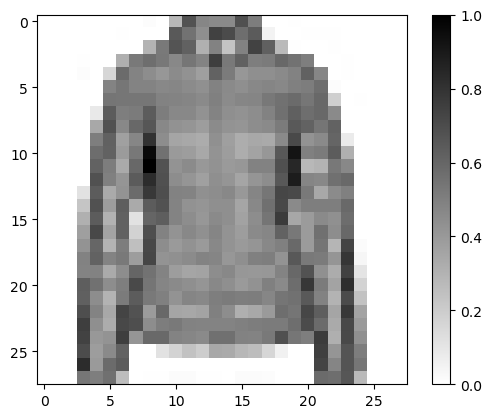

In [6]:
# retirons la dimension couleur et faisons un reshape

for image, label in test_dataset.take(1):
    break
image = image.numpy().reshape((28, 28))

# Représentation de l'image

plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

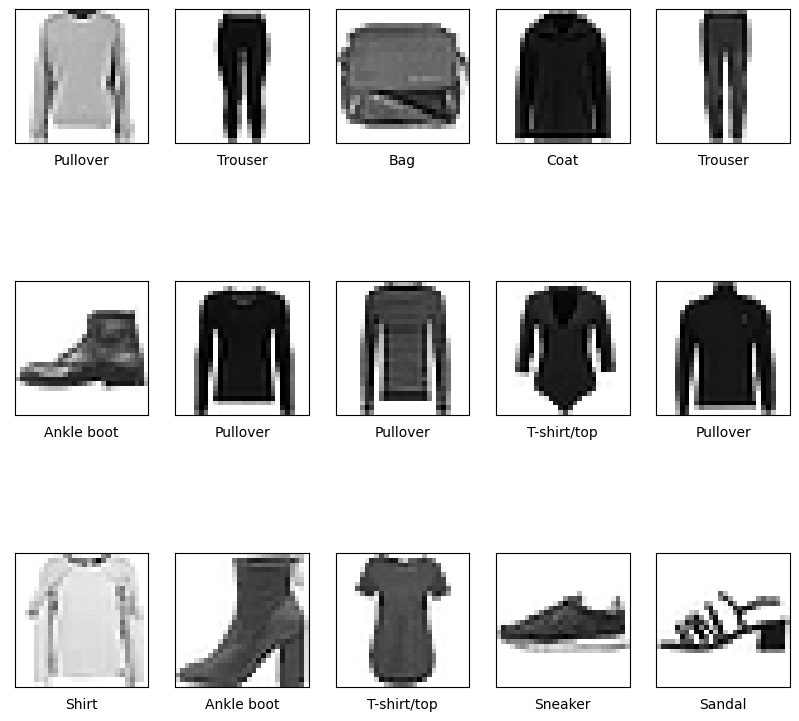

In [7]:
# Afficher les 15 premiéres images pour vérifier si les images sont suer un bon format avant de les entrainer

plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_dataset.take(15)):
    image = image.numpy().reshape((28, 28))
    plt.subplot(3, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image, cmap=plt.cm.binary)
    plt.xlabel(class_names[label])
plt.show()

### Construction du model

In [8]:
#Le bloc de construction de base d'un réseau de neurones est la couche. Une couche extrait une représentation des données qui y sont introduites,
#Espérons qu'une série de couches connectées donne une représentation significative pour le problème à résoudre.

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)# le nombre de couche a la sortie doit etre égale au nombre de classe
])

#Ce reseau a 3 couches:
#-input tf.keras.lyers.Flatten: Cette couche transforme les images d'un tableau 2d de 28 × 28 pixels en un tableau 1d de 784 pixels (28*28). 
#Considérez ce calque comme désempilant des rangées de pixels dans l'image et en les alignant. Cette couche n'a aucun paramètre à apprendre, 
#car elle ne fait que reformater les données.

# -"hidden" tf.keras.layers.Dense: Une couche densément connectée de 128 neurones. Chaque neurone (ou nœud) prend l'entrée des 784 nœuds 
#de la couche précédente, en pondérant cette entrée en fonction des paramètres cachés qui seront appris pendant l'apprentissage, 
#et envoie une valeur unique à la couche suivante.

#- output tf.keras.Dense: Un 128 neurones, suivi d'une couche softmax à 10 nœuds. Chaque nœud représente une classe de vêtements.
#Comme dans la couche précédente, la couche finale prend l'entrée des 128 nœuds de la couche précédente et génère une valeur dans la plage [0, 1],
#représentant la probabilité que l'image appartienne à cette classe. La somme des 10 valeurs de nœud est 1.

### Compilation du modèle

In [9]:
#Avant que le modèle ne soit prêt pour l'entraînement, il a besoin de quelques réglages supplémentaires. Ceux-ci sont ajoutés lors de l'étape 
#de compilation du modèle :

#- loss function: Un algorithme pour mesurer la distance entre les sorties du modèle et la sortie souhaitée. 
#Le but de la formation est de mesurer la perte.

#- Optimizer: algorithme permettant d'ajuster les paramètres internes du modèle afin de minimiser les pertes.
#- Metrics: Utilisé pour surveiller les étapes de formation et de test. L'exemple suivant utilise la précision, 
#la fraction des images correctement classées.

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
             metrics=['accuracy']
             )

### Entrainement du modèle

In [10]:
BATCH_SIZE = 32
train_dataset = train_dataset.cache().repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.cache().batch(BATCH_SIZE)

model.fit(train_dataset, epochs=5, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

Epoch 1/5
1875/1875 [==============================] - 4s 1ms/step - loss: 0.4923 - accuracy: 0.8269
Epoch 2/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.3686 - accuracy: 0.8667
Epoch 3/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.3386 - accuracy: 0.8755
Epoch 4/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.3093 - accuracy: 0.8859
Epoch 5/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2905 - accuracy: 0.8921


### Evaluation de la précision
comparons les performances du modèle sur l'ensemble de données de test.
Utilisez tous les exemples que nous avons dans l'ensemble de données de test pour évaluer le modèle.

In [12]:
test_loss, test_accuracy = model.evaluate(test_dataset, steps=math.ceil(num_test_examples/32))
print('Accuracy on test dataset:', test_accuracy)

313/313 [==============================] - 0s 963us/step - loss: 0.3793 - accuracy: 0.8656
Accuracy on test dataset: 0.8655999898910522


## Prédiction et exploiration

In [14]:
for test_images, test_labels in test_dataset.take(1):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()
  predictions = model.predict(test_images)

1/1 [==============================] - 0s 68ms/step


In [15]:
predictions.shape

(32, 10)

In [16]:
predictions[0]

array([3.6025805e-05, 1.9137128e-06, 5.1903710e-02, 3.6893232e-06,
       9.3610716e-01, 5.9413377e-11, 1.1939959e-02, 9.5848107e-10,
       7.4828481e-06, 1.6059425e-07], dtype=float32)

Une prédiction est un tableau de 10 nombres. Ceux-ci décrivent la "probabilité" du modèle que l'image correspond à chacun 
des 10 vêtements différents. Nous pouvons voir quelle étiquette a la valeur de confiance la plus élevée :

In [17]:
np.argmax(predictions[0])

4